In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pyccl as ccl
from scipy import optimize
import sacc
#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
from camb.sources import GaussianSourceWindow, SplinedSourceWindow

Using CAMB 1.3.2 installed at /global/common/software/lsst/common/miniconda/prod/envs/desc/lib/python3.8/site-packages/camb


## read n(z)

In [2]:
def gaussian(p, x):
    mu = p[0]
    sigma = p[1]
    return 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5*((x-mu)/sigma)**2)
def residual(p,func, y, x):
    return np.sum(((y-func(p, x)))**2)

In [3]:
s = sacc.Sacc.load_fits('../5x2/NKGK/LSST/Y1/SRD_sm/sacc.fits')

In [4]:
zs_arr = []
W_arr = []
bias_arr = []
for i in range(5):
    trcr = s.get_tracer(f'gc{i}')
    res = optimize.minimize(residual,[0.5,0.1], args=(gaussian, trcr.nz,trcr.z),method='Nelder-Mead', options={'xtol': 1e-10, 'disp': False})
    zs_arr.append(trcr.z)
    W_arr.append(gaussian(res.x,trcr.z))
    bias_arr.append(s.metadata[f'gc{i}_bias']+0*trcr.z)

## camb

In [5]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.0, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=2);

In [6]:
z0=0.311
zz = np.arange(0.0, 10.0, 0.02)
Nz = (zz**2)*np.exp(-(zz/0.26)**0.94)
bias = 1 + 1.05*zz
pars.SourceWindows = [SplinedSourceWindow(dlog10Ndm=0, z=zs_arr[i], W=W_arr[i], bias_z=bias_arr[i], source_type='counts') for i in range(5)]
lmax=3000
pars.set_for_lmax(lmax, lens_potential_accuracy=5)
results = camb.get_results(pars)
cl_camb=results.get_cmb_unlensed_scalar_array_dict()

In [7]:
ell = np.arange(2,cl_camb['PxP'].size)

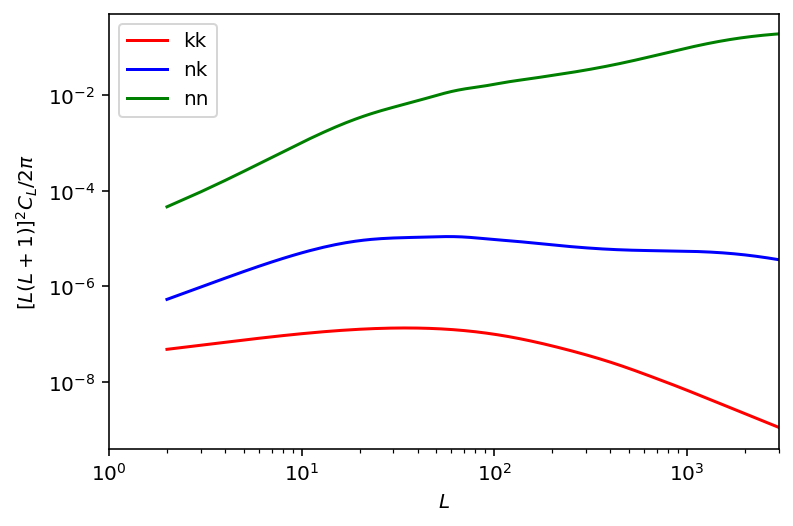

In [8]:
plt.loglog(np.arange(2,cl_camb['PxP'].size),cl_camb['PxP'][2:], color='r')
plt.loglog(np.arange(2,cl_camb['PxW1'].size),cl_camb['PxW1'][2:], color='b')
plt.loglog(np.arange(2,cl_camb['W1xW1'].size),cl_camb['W1xW1'][2:], color='g')
#plt.loglog(ell,cl)
plt.xlim([1,3000])
plt.legend(['kk','nk','nn'])
plt.ylabel('$[L(L+1)]^2C_L/2\pi$')
plt.xlabel('$L$');

In [9]:
kk_dict = {'kk':cl_camb['PxP'][2:]}
nk_dict = {}
nn_dict = {}
for i in range(1,6):
    nk_dict[f'n{i}k'] = cl_camb[f'PxW{i}'][2:]
    for j in range(1,6):
        nn_dict[f'n{i}n{j}'] = cl_camb[f'W{i}xW{j}'][2:]

In [10]:
# for each ell, compute the correlation
rho_l = []
for l in range(len(ell)):
    rho_jk = np.zeros(5)
    for j in range(1,6):
        rho_jk[j-1] = (nk_dict[f'n{j}k'][l]/
                       np.sqrt(nn_dict[f'n{j}n{j}'][l]*
                               kk_dict['kk'][l]))
    rho_ij = np.zeros((5,5))
    for i in range(1,6):
        for j in range(1,6):
            rho_ij[i-1][j-1] = (nn_dict[f'n{i}n{j}'][l]/
                                np.sqrt(nn_dict[f'n{i}n{i}'][l]*
                                        nn_dict[f'n{j}n{j}'][l]))
    rho_l.append(np.dot(rho_jk, np.dot(np.linalg.inv(rho_ij),rho_jk)))
rho_l = np.array(rho_l)

Text(0.5, 1.0, 'CL_KK')

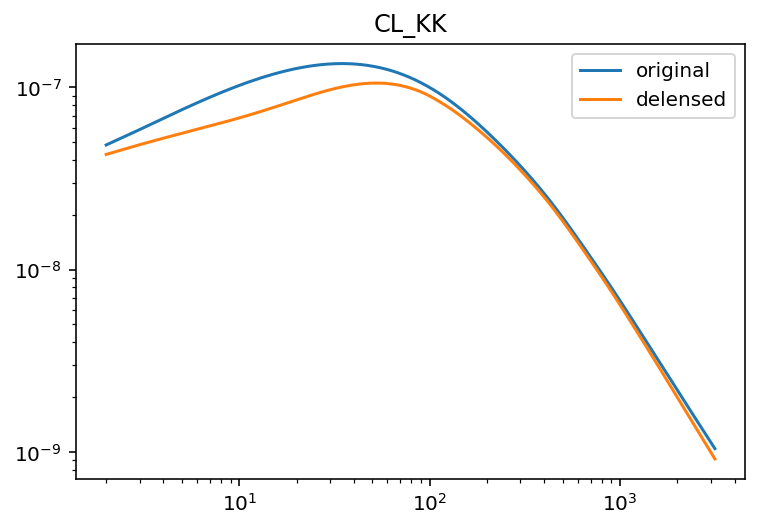

In [11]:
plt.loglog(ell,kk_dict['kk'],label='original')
plt.loglog(ell,(1-rho_l**2)*kk_dict['kk'],label='delensed')
plt.legend()
plt.title('CL_KK')

## CCL

In [12]:
import pyccl as ccl

In [13]:
# H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.0, omk=0, tau=0.06
m_nuSum = 0.0
h = 0.675
om_c = 0.122
om_b = 0.022
ns = 0.965
A_s_single = 2e-09

cosmo = ccl.Cosmology(Omega_c = om_c*h**-2,
                             Omega_b = om_b*h**-2,
                             h = h,
                             n_s = ns,
                             A_s = A_s_single,
                             Neff=2.046,
                             m_nu = m_nuSum,
                             m_nu_type='single',
                             transfer_function='boltzmann_camb'
                            )

In [14]:
ell = np.arange(2,cl_camb['PxP'].size)

In [15]:
trcr_k = ccl.tracers.CMBLensingTracer(cosmo, z_source=1100., n_samples=100)
trcr_n = ccl.tracers.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zs_arr[0],W_arr[0]), bias=(zs_arr[0],bias_arr[0]), mag_bias=None)

In [16]:
kk_ccl = ccl.angular_cl(cosmo, trcr_k, trcr_k, ell)
nk_ccl = ccl.angular_cl(cosmo, trcr_n, trcr_k, ell)
nn_ccl = ccl.angular_cl(cosmo, trcr_n, trcr_n, ell)

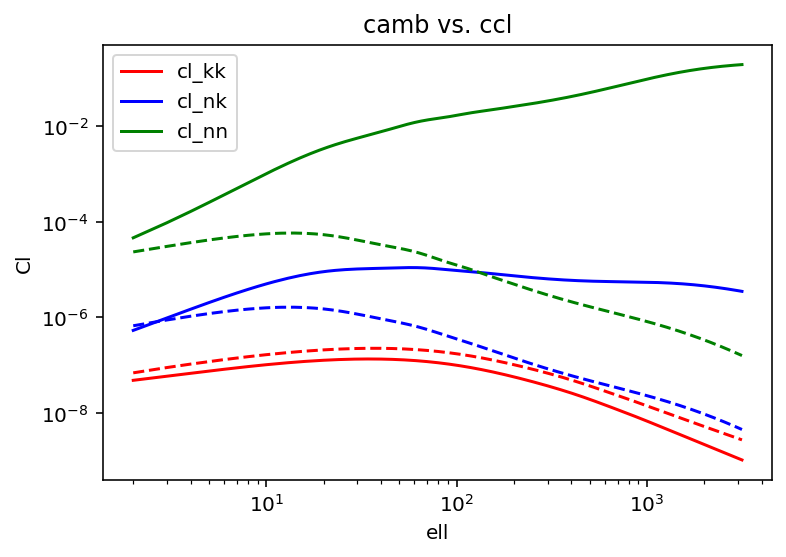

In [17]:
plt.loglog(np.arange(2,cl_camb['PxP'].size),cl_camb['PxP'][2:], color='r',label='cl_kk')
plt.loglog(np.arange(2,cl_camb['PxW1'].size),cl_camb['PxW1'][2:], color='b', label='cl_nk')
plt.loglog(np.arange(2,cl_camb['W1xW1'].size),cl_camb['W1xW1'][2:], color='g', label='cl_nn')
plt.loglog(ell, kk_ccl, color='r', ls='--')
plt.loglog(ell, nk_ccl, color='b', ls='--')
plt.loglog(ell, nn_ccl, color='g', ls='--')
plt.xlabel('ell')
plt.ylabel('Cl')
plt.title('camb vs. ccl')
plt.legend()